In [57]:
import sys
import os
sys.path.append(os.getcwd()[:os.getcwd().rfind('/')])
from davidplayground.datasets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import backtesting as bt
import pandas_ta as ta
sns.set()

In [147]:
ltc = CoinDataset(name="LTC")
data = ltc.get(start="2021-06-08", end="2021-06-15", granularity=300)
data.columns = [c.capitalize() for c in data.columns]
data = data.set_index(data["Time"])
data.head(10), len(data)

(                      Close    High     Low    Open                Time  \
 Time                                                                      
 2021-06-07 20:00:00  162.38  162.81  160.82  161.98 2021-06-07 20:00:00   
 2021-06-07 20:05:00  163.52  163.64  162.02  162.38 2021-06-07 20:05:00   
 2021-06-07 20:10:00  163.96  164.53  163.40  163.59 2021-06-07 20:10:00   
 2021-06-07 20:15:00  164.12  164.58  163.73  163.78 2021-06-07 20:15:00   
 2021-06-07 20:20:00  163.82  164.23  163.61  164.12 2021-06-07 20:20:00   
 2021-06-07 20:25:00  162.07  163.88  161.82  163.86 2021-06-07 20:25:00   
 2021-06-07 20:30:00  160.93  162.21  160.48  162.13 2021-06-07 20:30:00   
 2021-06-07 20:35:00  160.73  161.26  160.20  160.92 2021-06-07 20:35:00   
 2021-06-07 20:40:00  160.62  161.41  160.54  160.73 2021-06-07 20:40:00   
 2021-06-07 20:45:00  161.72  161.81  160.48  160.50 2021-06-07 20:45:00   
 
                           Volume  
 Time                              
 2021-06-07 20

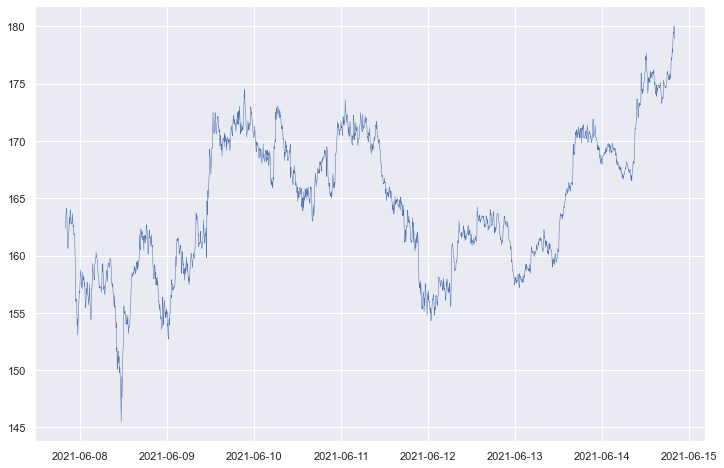

In [148]:
plt.plot(data['Time'], data['Close'], lw=0.5)
plt.gcf().set_size_inches((12.,8.))
plt.show()

In [154]:
from backtesting.lib import crossover
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()
def EMA(values, n):
    return pd.DataFrame(values).ta.ema(length=n)
class SmaCross(bt.Strategy):
    n1 = 12
    n2 = 96
    def init(self, n1=None, n2=None):
        if not n1:
            n1 = self.n1
        if not n2:
            n2 = self.n2
        self.sma1 = self.I(EMA, self.data.Close, n1)
        self.sma2 = self.I(EMA, self.data.Close, n2)
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close(portion=0.5)
            self.buy(size=0.5)

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close(portion=0.5)
            self.sell(size=0.5)

In [155]:
back = bt.Backtest(data, SmaCross, cash=10_000, commission=0.002)
stats = back.run()#back.optimize(n1=range(1,30), n2=range(2,60), method='grid', constraint=lambda p: p.n1 < p.n2)
stats

Start                     2021-06-07 20:00:00
End                       2021-06-14 20:00:00
Duration                      7 days 00:00:00
Exposure Time [%]                   94.967933
Equity Final [$]                   10019.3506
Equity Peak [$]                   10128.48538
Return [%]                           0.193506
Buy & Hold Return [%]               10.185983
Return (Ann.) [%]                    9.220851
Volatility (Ann.) [%]               26.716528
Sharpe Ratio                         0.345137
Sortino Ratio                        0.611428
Calmar Ratio                         2.705848
Max. Drawdown [%]                   -3.407749
Avg. Drawdown [%]                   -0.832988
Max. Drawdown Duration        4 days 22:35:00
Avg. Drawdown Duration        0 days 19:56:00
# Trades                                   57
Win Rate [%]                        36.842105
Best Trade [%]                       6.571851
Worst Trade [%]                     -2.302677
Avg. Trade [%]                    

In [156]:
back.plot(show_legend=False)

Row(id='11458', ...)

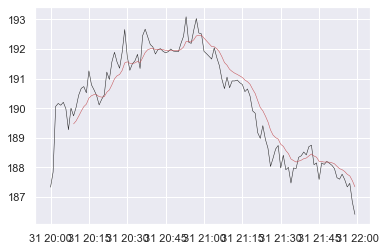

<Strategy SmaCross>

In [138]:
ex = data.head(120)
fig, ax = plt.subplots()
ax.plot(ex['Time'], ex['Close'], lw=0.5, c='k')
ax.plot(ex['Time'], ex.ta.ema(), lw=0.5, c='r')
plt.show()
stats._strategy